In [2]:
import sys
import util
from Polygenic_score import *

import os
import subprocess
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import re
import sklearn.metrics
from tqdm import tqdm

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def clump_sorted_snps(bfile, assoc_file, snp_values, sorted_snps):

    clump_out = assoc_file[:assoc_file.index(".assoc")] + "_clump"
    cmd_plink_clump = "plink --bfile {} --clump {} --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out {} ".format(bfile,
            assoc_file,
            clump_out)
    print cmd_plink_clump
    p = subprocess.Popen(cmd_plink_clump, shell=True)
    p.wait()

    clumped_res = pd.read_table(clump_out+".clumped", delim_whitespace=True)
    clumped_snps = set(clumped_res.SNP)

    clumped_sorted_snps = np.array([i for i in sorted_snps if snp_values[i] in clumped_snps])
    return clumped_sorted_snps



In [4]:
def save_strat(strat_file, strat):
    pca_res = pd.read_table(strat_file, delim_whitespace=True, skiprows=1, header=None)
    PCs_out = strat + ".PCs"
    #with open("res_clumped/"+PCs_out, "a") as f:
    with open(PCs_out, "a") as f:
        f.write(', '.join(str(pca_res[0].values)))
        f.write('\n')
        f.write(str(pca_res[2].values.tolist())[1:-1])
        f.write('\n')
        f.write(str(pca_res[3].values.tolist())[1:-1])
        f.write('\n')


In [5]:
def plink_prune(plink_bfile):

    cmd_prune = """plink --bfile {}      --exclude /home/vcabeli/Documents/data/high-LD-regions_37.txt           --range --indep-pairwise 50 5 0.2           --allow-extra-chr           --out {}""".format(plink_bfile, plink_bfile+"_prune")
    p = subprocess.Popen(cmd_prune, shell=True)
    assert(p.wait() == 0)

    cmd_extract = """plink --bfile {}           --extract {}           --allow-extra-chr           --chr 1-23           --make-bed           --out {}""".format(plink_bfile, plink_bfile + "_prune.prune.in", 
                             plink_bfile + "_pruned")
    p = subprocess.Popen(cmd_extract, shell=True)
    assert(p.wait() == 0)

    print "Wrote {} bed/bim/fam.".format(plink_bfile + "_pruned")



In [6]:
def write_cov_file(pca_file,nb_pc=2):

    cmd_sed = "sed -i -e \"s/:/ /g\" -e \"s/\s\+/\t/g\" -e \"s/^\s\+//g\" {}".format(pca_file)
    p = subprocess.Popen(cmd_sed, shell=True)
    assert(p.wait()==0)
    
    cov_file = pca_file[:-9]+".cov"
    a=""
    for i in range(nb_pc):
        a=a+("\tPC{}".format(i+1))
    

    cmd_print = "printf \"FID\tIID{}\n\" > {}".format(a,cov_file)

    p = subprocess.Popen(cmd_print, shell=True)
    assert(p.wait()==0)

    cmd_tail = "tail -n+2 {} | cut -f1-{} >> {}".format(pca_file, 2+nb_pc, cov_file) 

    #-n+2 récup lignes en commançant par le 2ème
    #-f1-2+nb_pc résup les champs 1-nb_pc+2
    
    p = subprocess.Popen(cmd_tail, shell=True)
    assert(p.wait()==0)
    
    print "Wrote {}".format(cov_file)

In [218]:
 def select_snp(nb_snps):
    snp_gene_table = pd.read_table("/home/vcabeli/Documents/data/BP_final/BP.B37-final.bim",
                                   delim_whitespace=True,names=["chr","snp","distance","position","Allele_1","Allele_2"])


    indx=np.random.choice(snp_gene_table.shape[0],nb_snps)
    snp_extract=snp_gene_table.snp[indx]
    #ecriture du fichier contenant la liste des snp a garder 
    extract_file=str(nb_snps)+"_snps.extract"
    set_file=str(nb_snps)+"_snps_set"
    with open(extract_file, 'w') as f:
        for snp in snp_extract:
                f.write(snp)
                f.write("\n")
    #ecriture fichier bim/bed/fam contenant 50 snps
    cmd_keep_plink = "plink --bfile {} --extract {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                     extract_file,
                                                                                     set_file)
    print cmd_keep_plink
    p = subprocess.Popen(cmd_keep_plink, shell=True)
    p.wait()
    return(set_file)

In [286]:
def iterate(n_iter,threshs,nb_pc,data):
    res_hw_pval_sign = np.zeros([n_iter, len(threshs)])
    for iteration in range(n_iter):

        print "=========================Iteration {}=========================".format(iteration)
        # extraction des SNPs indépendantes selon le seuil de LD 
        cmd_extract_low_ld_snps = "plink --bfile {} --extract {} --make-bed --out {}".format(data,
                                                                                             "L2_thresh_{}_BP.extract".format(thresh_LD),
                                                                                             "low_ld")
        print cmd_extract_low_ld_snps
        p = subprocess.Popen(cmd_extract_low_ld_snps, shell=True)
        assert(p.wait()==0)

        plink_prune("low_ld")



        # Covariables
        if(nb_pc!=0):
            cmd_smart_pca2 = "smartpca.perl -i {} -a {} -b {} -o {} -p {} -e {} -l {} -k {} -t {} -m {}".format("low_ld_pruned.bed",
                                                                                                               "low_ld_pruned.bim",
                                                                                                               "low_ld_pruned.fam",
                                                                                                               "low_ld_pruned.pca",
                                                                                                               "low_ld_pruned.plot",
                                                                                                               "low_ld_pruned.eval",
                                                                                                               "low_ld_pruned.log",
                                                                                                               nb_pc, 2, 0)
            print cmd_smart_pca2
            p = subprocess.Popen(cmd_smart_pca2, shell=True)
            p.wait()


            write_cov_file("low_ld_pruned.pca.evec",nb_pc)
            save_strat("low_ld_pruned.pca.evec", "low_ld{}".format(thresh_LD)) #OUTPUT LINE


        # Split training / testing datasets

        snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")

        train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)

        test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)
 



        training_sample_out = "training_samples.keep"

        with open(training_sample_out, 'w') as f:
            for i in train_idces:
                f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
                f.write("\n")

        # #### Build training set bed bim fam

        cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                 training_sample_out,
                                                                                 "training_set")
        print cmd_keep_plink
        p = subprocess.Popen(cmd_keep_plink, shell=True)
        p.wait()
        # Association
        if (nb_pc==0):
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --out {}".format("training_set","low_ld")
        elif(nb_pc==1):
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1 --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                           "low_ld")
        else:
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1-PC{} --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                            nb_pc,
                                                                                                           "low_ld")
        print cmd_second_gwas
        p = subprocess.Popen(cmd_second_gwas, shell=True)
        p.wait()
        low_ld_res = pd.read_table("low_ld.assoc.logistic", delim_whitespace=True)

        # ### Compute PRS


        # Coded genotype (hardy-weinberg)
        G_hw = snp_data.val.copy()

        MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)
        G_hw = (2-G_hw - 2*MAFs)/np.sqrt(2*MAFs*(1-MAFs))



        sorted_snps_low_ld = np.argsort(low_ld_res.P)
        sorted_snps_low_ld = clump_sorted_snps("training_set", "low_ld.assoc.logistic",snp_data.col, sorted_snps_low_ld)

        prs_low_ld = polygen_score_sign(G_hw, sorted_snps_low_ld,
                                        threshs,
                                        test_idces, pheno,
                                        low_ld_res.BETA)
        res_hw_pval_sign[iteration] = prs_low_ld
    return(res_hw_pval_sign)

In [302]:
data_50=select_snp(50)
data_100=select_snp(100)
data_200=select_snp(200)
data_500=select_snp(500)
data_1000=select_snp(1000)
data_2000=select_snp(2000)
nb_pc_tot=11
threshs = range(10, 95000, 1000)
n_iter=1
time_pc = range(0,nb_pc_tot)
get_color = lambda : "#" + "".join(np.random.choice(list("02468acef"), size=6))
auc_50 = np.zeros([nb_pc_tot,n_iter,len(threshs)])
auc_100 = np.zeros([nb_pc_tot,n_iter,len(threshs)])
auc_200 = np.zeros([nb_pc_tot,n_iter,len(threshs)])
auc_500 = np.zeros([nb_pc_tot,n_iter,len(threshs)])
auc_1000 = np.zeros([nb_pc_tot,n_iter,len(threshs)])
auc_2000 = np.zeros([nb_pc_tot,n_iter,len(threshs)])

plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract 50_snps.extract --make-bed --out 50_snps_set
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract 100_snps.extract --make-bed --out 100_snps_set
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract 200_snps.extract --make-bed --out 200_snps_set
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract 500_snps.extract --make-bed --out 500_snps_set
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract 1000_snps.extract --make-bed --out 1000_snps_set
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract 2000_snps.extract --make-bed --out 2000_snps_set


### Calcul des covariables pour 50 snps

In [305]:
for PC in range(0,nb_pc_tot):
        print "========================= {} PCs =========================".format(PC)
        #auc_50[PC]=iterate(n_iter,threshs,PC,data_50)
        auc_100[PC]=iterate(n_iter,threshs,PC,data_100)
        auc_200[PC]=iterate(n_iter,threshs,PC,data_200)
        auc_500[PC]=iterate(n_iter,threshs,PC,data_500)
        auc_1000[PC]=iterate(n_iter,threshs,PC,data_1000)
        auc_2000[PC]=iterate(n_iter,threshs,PC,data_2000)

========================= 0 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld


Wrote low_ld_pruned bed/bim/fam.
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.33it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld


Wrote low_ld_pruned bed/bim/fam.
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.25it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld


Wrote low_ld_pruned bed/bim/fam.
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.10it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld


Wrote low_ld_pruned bed/bim/fam.
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.14it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld


Wrote low_ld_pruned bed/bim/fam.
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.87it/s]


========================= 1 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 1 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.62it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 1 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.44it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 1 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.88it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 1 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 17.98it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 1 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 17.85it/s]


========================= 2 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.28it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.27it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.86it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.25it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.37it/s]


========================= 3 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.42it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.47it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.29it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.04it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.47it/s]


========================= 4 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.74it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.27it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.85it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.28it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.60it/s]


========================= 5 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 5 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC5 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.18it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 5 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC5 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.44it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 5 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC5 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.47it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 5 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC5 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.30it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 5 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC5 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.17it/s]


========================= 6 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 6 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC6 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.52it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 6 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC6 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.21it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 6 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC6 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.40it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 6 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC6 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.47it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 6 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC6 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.24it/s]


========================= 7 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 7 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC7 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.30it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 7 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC7 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.04it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 7 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC7 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.22it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 7 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC7 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.31it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 7 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC7 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.08it/s]


========================= 8 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 8 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC8 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.22it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 8 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC8 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.26it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 8 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC8 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.66it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 8 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC8 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.11it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 8 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC8 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.18it/s]


========================= 9 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 9 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC9 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.08it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 9 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC9 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.44it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 9 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC9 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.69it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 9 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC9 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.13it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 9 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC9 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.65it/s]


========================= 10 PCs =========================
=========================Iteration 0=========================
plink --bfile 100_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.24it/s]


=========================Iteration 0=========================
plink --bfile 200_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.26it/s]


=========================Iteration 0=========================
plink --bfile 500_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.80it/s]


=========================Iteration 0=========================
plink --bfile 1000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.01it/s]


=========================Iteration 0=========================
plink --bfile 2000_snps_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0


Wrote low_ld_pruned.cov
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.14it/s]


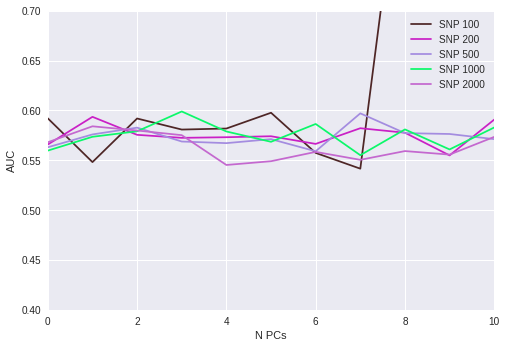

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.59210165  0.54820746  0.59195469  0.5808614   0.58188841  0.59772126
  0.5574324   0.54160556  0.88869735  0.89192803  0.89871757]


In [308]:
#sns.tsplot(auc_50.mean(axis=(1,2)),time_pc,color=get_color(),ci=[0,95], condition="SNP 50")
sns.tsplot(auc_100.mean(axis=(1,2)),time_pc,color=get_color(),ci=[0,95], condition="SNP 100")
sns.tsplot(auc_200.mean(axis=(1,2)),time_pc,color=get_color(),ci=[0,95], condition="SNP 200")
sns.tsplot(auc_500.mean(axis=(1,2)),time_pc,color=get_color(),ci=[0,95], condition="SNP 500")
sns.tsplot(auc_1000.mean(axis=(1,2)),time_pc,color=get_color(),ci=[0,95], condition="SNP 1000")
sns.tsplot(auc_2000.mean(axis=(1,2)),time_pc,color=get_color(),ci=[0,95], condition="SNP 2000")
sns.plt.ylim(0.4,0.7)
sns.plt.ylabel('AUC')
sns.plt.xlabel('N PCs')

plt.show()
print auc_50.mean(axis=(1,2))
print auc_100.mean(axis=(1,2))

[array([ 0.48744443,  0.50410476,  0.51894344,  0.53892136,  0.54400029,
        0.55421847,  0.57392495,  0.57622917,  0.58578383,  0.5811573 ,
        0.58132016,  0.57657299,  0.57920897,  0.57661521,  0.57803876,
        0.57486594,  0.56596273,  0.55941803,  0.55657697,  0.55460451,
        0.55338002,  0.55056912,  0.5551112 ,  0.55681825,  0.55812719,
        0.55756622,  0.55959296,  0.56071491,  0.56022632,  0.55723446,
        0.55096723,  0.54769789,  0.55287333,  0.55161868,  0.54702834,
        0.55082849,  0.54897064,  0.55125073,  0.55020117,  0.55060531,
        0.55192028,  0.55027355,  0.55082246,  0.55208314,  0.55541883,
        0.55593758,  0.55729478,  0.55813322,  0.55918279,  0.55476738,
        0.55699921,  0.55474325,  0.55692683,  0.55564201,  0.5554128 ,
        0.55821164,  0.55549725,  0.55623315,  0.55483373,  0.5556963 ,
        0.55283714,  0.55423656,  0.55039419,  0.550925  ,  0.55430895,
        0.55525597,  0.55559979,  0.55707159,  0.55713191,  0.5

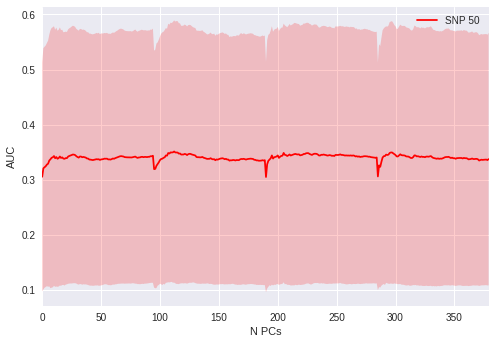

In [263]:
liste=[]
for ele in auc_50:
    liste.append(np.power(ele.ravel(),1))
print liste

sns.tsplot(np.power(liste,1),color='r',ci=[0,95], condition="SNP 50")
#sns.tsplot(np.power(auc_50.ravel(),1),time_pc,color='b',ci=[0,95], condition="SNP 500")
sns.plt.ylabel('AUC')
sns.plt.xlabel('N PCs')
plt.show()

### Association sur toute les snps

In [177]:
snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")

Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.


In [187]:
# Split training / testing datasets

train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)
print len(train_idces)
test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)
print len(test_idces)



training_sample_out = "training_samples.keep"

with open(training_sample_out, 'w') as f:
    for i in train_idces:
        f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
        f.write("\n")
# #### Build training set bed bim fam



cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                         training_sample_out,
                                                                         "training_set")
print cmd_keep_plink
p = subprocess.Popen(cmd_keep_plink, shell=True)
p.wait()


976
976
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set


0

In [188]:
# Association
cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1-PC{} --out {}".format("training_set",
                                                                                                   "low_ld_pruned.cov",
                                                                                                    4,
                                                                                                   "low_ld")
print cmd_second_gwas
p = subprocess.Popen(cmd_second_gwas, shell=True)
p.wait()
low_ld_res = pd.read_table("low_ld.assoc.logistic", delim_whitespace=True)


plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld


In [189]:
low_ld_res.head()

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,1,rs3934834,1005806,T,ADD,966,-0.19510,-1.2020,0.2294
1,1,rs3737728,1021415,A,ADD,974,-0.02802,-0.2231,0.8234
2,1,rs6687776,1030565,T,ADD,976,0.02400,0.1579,0.8746
3,1,rs9651273,1031540,A,ADD,974,0.11500,0.9263,0.3543
4,1,rs4970405,1048955,G,ADD,975,0.19760,1.1300,0.2583


In [190]:
# #### Coded genotype (hardy-weinberg)
# 
# With sufficiently large cohorts, traning and test sets should have the same MAFs. The coded genotype is computed on the whole dataset.



G_hw = snp_data.val.copy()

MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)
G_hw = (2-G_hw - 2*MAFs)/np.sqrt(2*MAFs*(1-MAFs))


# ### Compute PRS
sorted_snps_low_ld = np.argsort(low_ld_res.P)
print len(sorted_snps_low_ld)

250140


In [191]:

sorted_snps_low_ld = clump_sorted_snps("training_set", "low_ld.assoc.logistic",snp_data.col, sorted_snps_low_ld)


print len(sorted_snps_low_ld)

plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 
94984


In [192]:
threshs = range(10, 95000, 1000)
prs_low_ld = polygen_score_sign(G_hw, sorted_snps_low_ld,
                                threshs,
                                test_idces, pheno,
                                low_ld_res.BETA)


100%|██████████| 95/95 [00:05<00:00, 18.79it/s]


In [199]:
auc_50 = np.zeros([nb_pc_tot-2,1,len(threshs)])
auc_50[2][0]=prs_low_ld
print prs_low_ld.mean()
auc_50.mean(axis=(1,2))

0.868487511601


array([ 0.57477109,  0.54965045,  0.89097429])

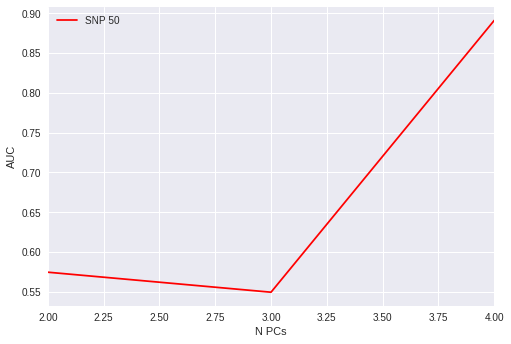

In [200]:
sns.tsplot(auc_50.mean(axis=(1,2)),time_pc,color='r',ci=[0,95], condition="SNP 50")

sns.plt.ylabel('AUC')
sns.plt.xlabel('N PCs')
plt.show()
